In [18]:
import re  # regular expressions

# for mathemactical computation, oraganization and visualization of data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# for data preprocessing, model training and model evaluation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import nltk # for stemming and stopwords removal

In [19]:
data = pd.read_csv('amazon_alexa.tsv',sep='\t')
data.shape

(3150, 5)

In [20]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


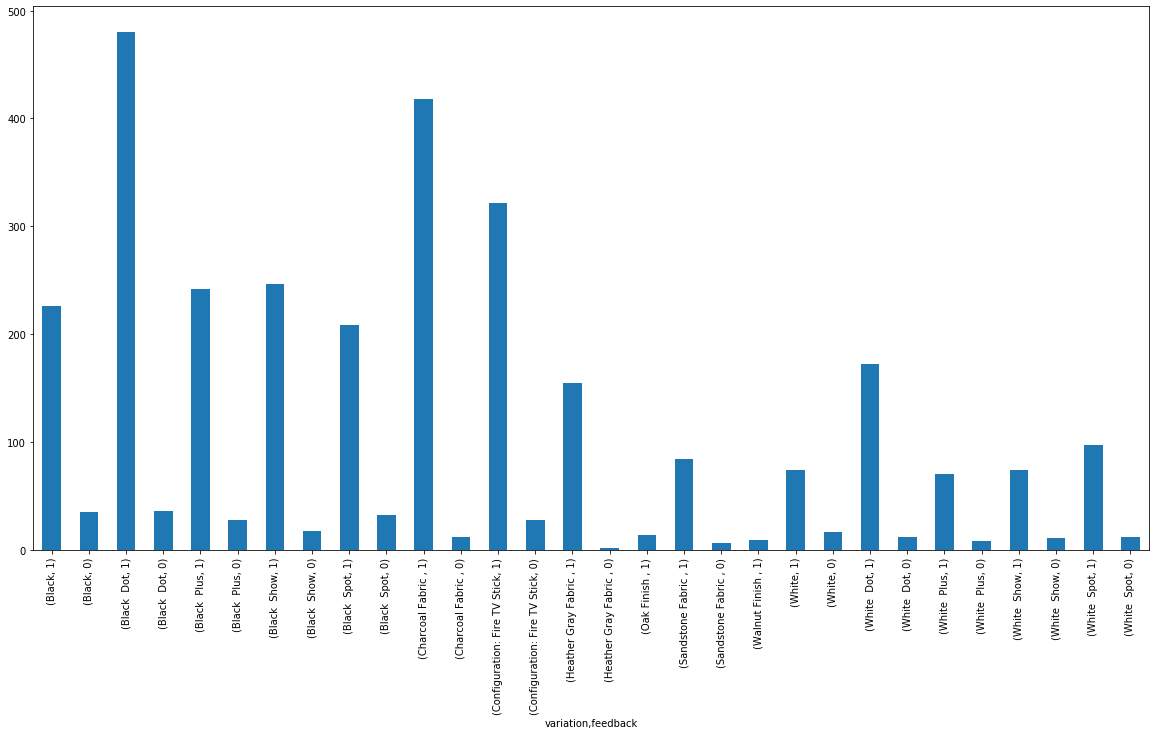

In [21]:
plt.rcParams["figure.figsize"] = (20,10)
data.groupby(['variation']).feedback.value_counts().plot(kind='bar')

In [22]:
data['variation'].nunique()

16

In [23]:
data.isna().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [24]:
data.drop(['rating','date'], inplace=True, axis=1)
data.head()

,variation,verified_reviews,feedback
0,Charcoal Fabric,Love my Echo!,1
1,Charcoal Fabric,Loved it!,1
2,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,Charcoal Fabric,Music,1


In [25]:
import collections
collections.Counter(data['feedback'])

Counter({1: 2893, 0: 257})

### Text Preprocessing

In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shahr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
stop_words = set(nltk.corpus.stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanpunc(sentence):
    cleaned = re.sub(r"[?|!|\'|\"|#]", r"",sentence)
    cleaned =  re.sub(r"[.|,|)|(|\|/]",r"",cleaned)
    return cleaned.lower()

sentences = data['verified_reviews'].values
reviews = []
for sent in sentences:
    cleaned_sent = cleanpunc(sent)
    sent_arr = cleaned_sent.split()
    output_sent = ''
    for word in sent_arr:
        if word not in stop_words:
            stemmed_word = sno.stem(word)
            output_sent = output_sent + ' ' + stemmed_word
    reviews.append(output_sent)

reviews_text = pd.DataFrame({'reviews': reviews})
data = pd.concat([data,reviews_text], axis=1)
data.head()

,variation,verified_reviews,feedback,reviews
0,Charcoal Fabric,Love my Echo!,1,love echo
1,Charcoal Fabric,Loved it!,1,love
2,Walnut Finish,"Sometimes while playing a game, you can answer...",1,sometim play game answer question correct ale...
3,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,lot fun thing 4 yr old learn dinosaur control...
4,Charcoal Fabric,Music,1,music


### Resample unbalance Data

In [29]:
data.drop(['verified_reviews'], axis=1,inplace=True)

from sklearn.utils import resample
data_majority = data[data.feedback == 1]
data_minority = data[data.feedback == 0]
data_minority_upsampled = resample(data_minority,
                                   replace=True,n_samples=2500,random_state=123)
data_upsampled = pd.concat([data_majority, data_minority_upsampled])
final = pd.concat([data_upsampled,
                   pd.get_dummies(data_upsampled['variation'],sparse=True)], axis=1)

final.shape

final.drop(['variation'], axis=1, inplace=True)
final.head()

,feedback,reviews,Black,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot
0,1,love echo,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,love,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,sometim play game answer question correct ale...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,lot fun thing 4 yr old learn dinosaur control...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,music,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


### Apply Bag of Words on the Textual feature 

In [30]:
count_vect = CountVectorizer(ngram_range=(1,2))
final_counts = count_vect.fit_transform(final['reviews'].values)
print(final_counts.get_shape())
print(final.shape)
final.drop(['reviews'],axis=1,inplace=True)

(5393, 24906)
(5393, 18)


In [31]:
rev_df = pd.DataFrame(final_counts.todense(),columns=count_vect.get_feature_names())

In [32]:
rev_df.shape

(5393, 24906)

In [33]:
final.reset_index(inplace=True, drop=True)
final_df = pd.concat([final,rev_df], axis=1)

In [63]:
final_df.iloc[:,16:]

,White Spot,072318,072318 part,10,10 20,10 30pm,10 alway,10 cheaper,10 connect,10 day,...,zigbe fair,zigbe hub,zigbe light,zonked,zonked out,zzzz,zzzzzzz,zzzzzzz still,útil,útil week
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5388,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5389,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
final_df.shape

(5393, 24923)

#### Model

In [38]:
X = final_df.iloc[:,1:].values
y = np.ravel(final_df.iloc[:,0:1].values)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

#### GridSearchCV to find optimal Hyperparameter

In [44]:
clf = MultinomialNB()
param_disb = { 'alpha': [10**-4,10**-3,10**-2,10**-1,10,1,10**2,10**3,10**4]}
search = GridSearchCV(clf, param_grid=param_disb, cv=5)
search.fit(X_train,y_train)

print(search.best_estimator_)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)


In [45]:
clf = MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
clf. fit(X_train, y_train)
print(confusion_matrix(y_test, clf.predict(X_test)))
print(f"Accuracy Score -> {clf.score(X_test,y_test)}")

[[776  55]
 [ 14 935]]
Accuracy Score -> 0.9612359550561798
